# Исследование участников ATI.SU

ATI.SU — биржа грузоперевозок и крупнейшая экосистема сервисов для транспортной логистики в России и СНГ

**Постановка задачи:**
- спарсить лучших активных участников ATI.SU.

**Цель проекта:** 

Проанализировать участников ATI.SU:
- спарсить всех участников;
- провести исследовательский анализ данных, определить все значимые признаки, влияющие на рейтинг;
- объединяя признаки, сформировать критерии для отбора лучших активных участников.

---------------------------------------
Импортируем библиотеки для работы:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import median
import datetime as dt
from datetime import datetime
import requests
import time
import re
import json
from io import BytesIO
import phik
from phik import phik_matrix

import warnings
# не показываем предупреждения
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 130

## Парсинг данных

Находим на сайте нужный нам запрос:

https://ati.su/gw/rating-page-service/public/v1/rating?atiDocs=false&atiOrders=false&autopark=false&firmTypes=1&geoId=1&geoTypeId=0&reverse=false&skip=0&take=20&verified=false

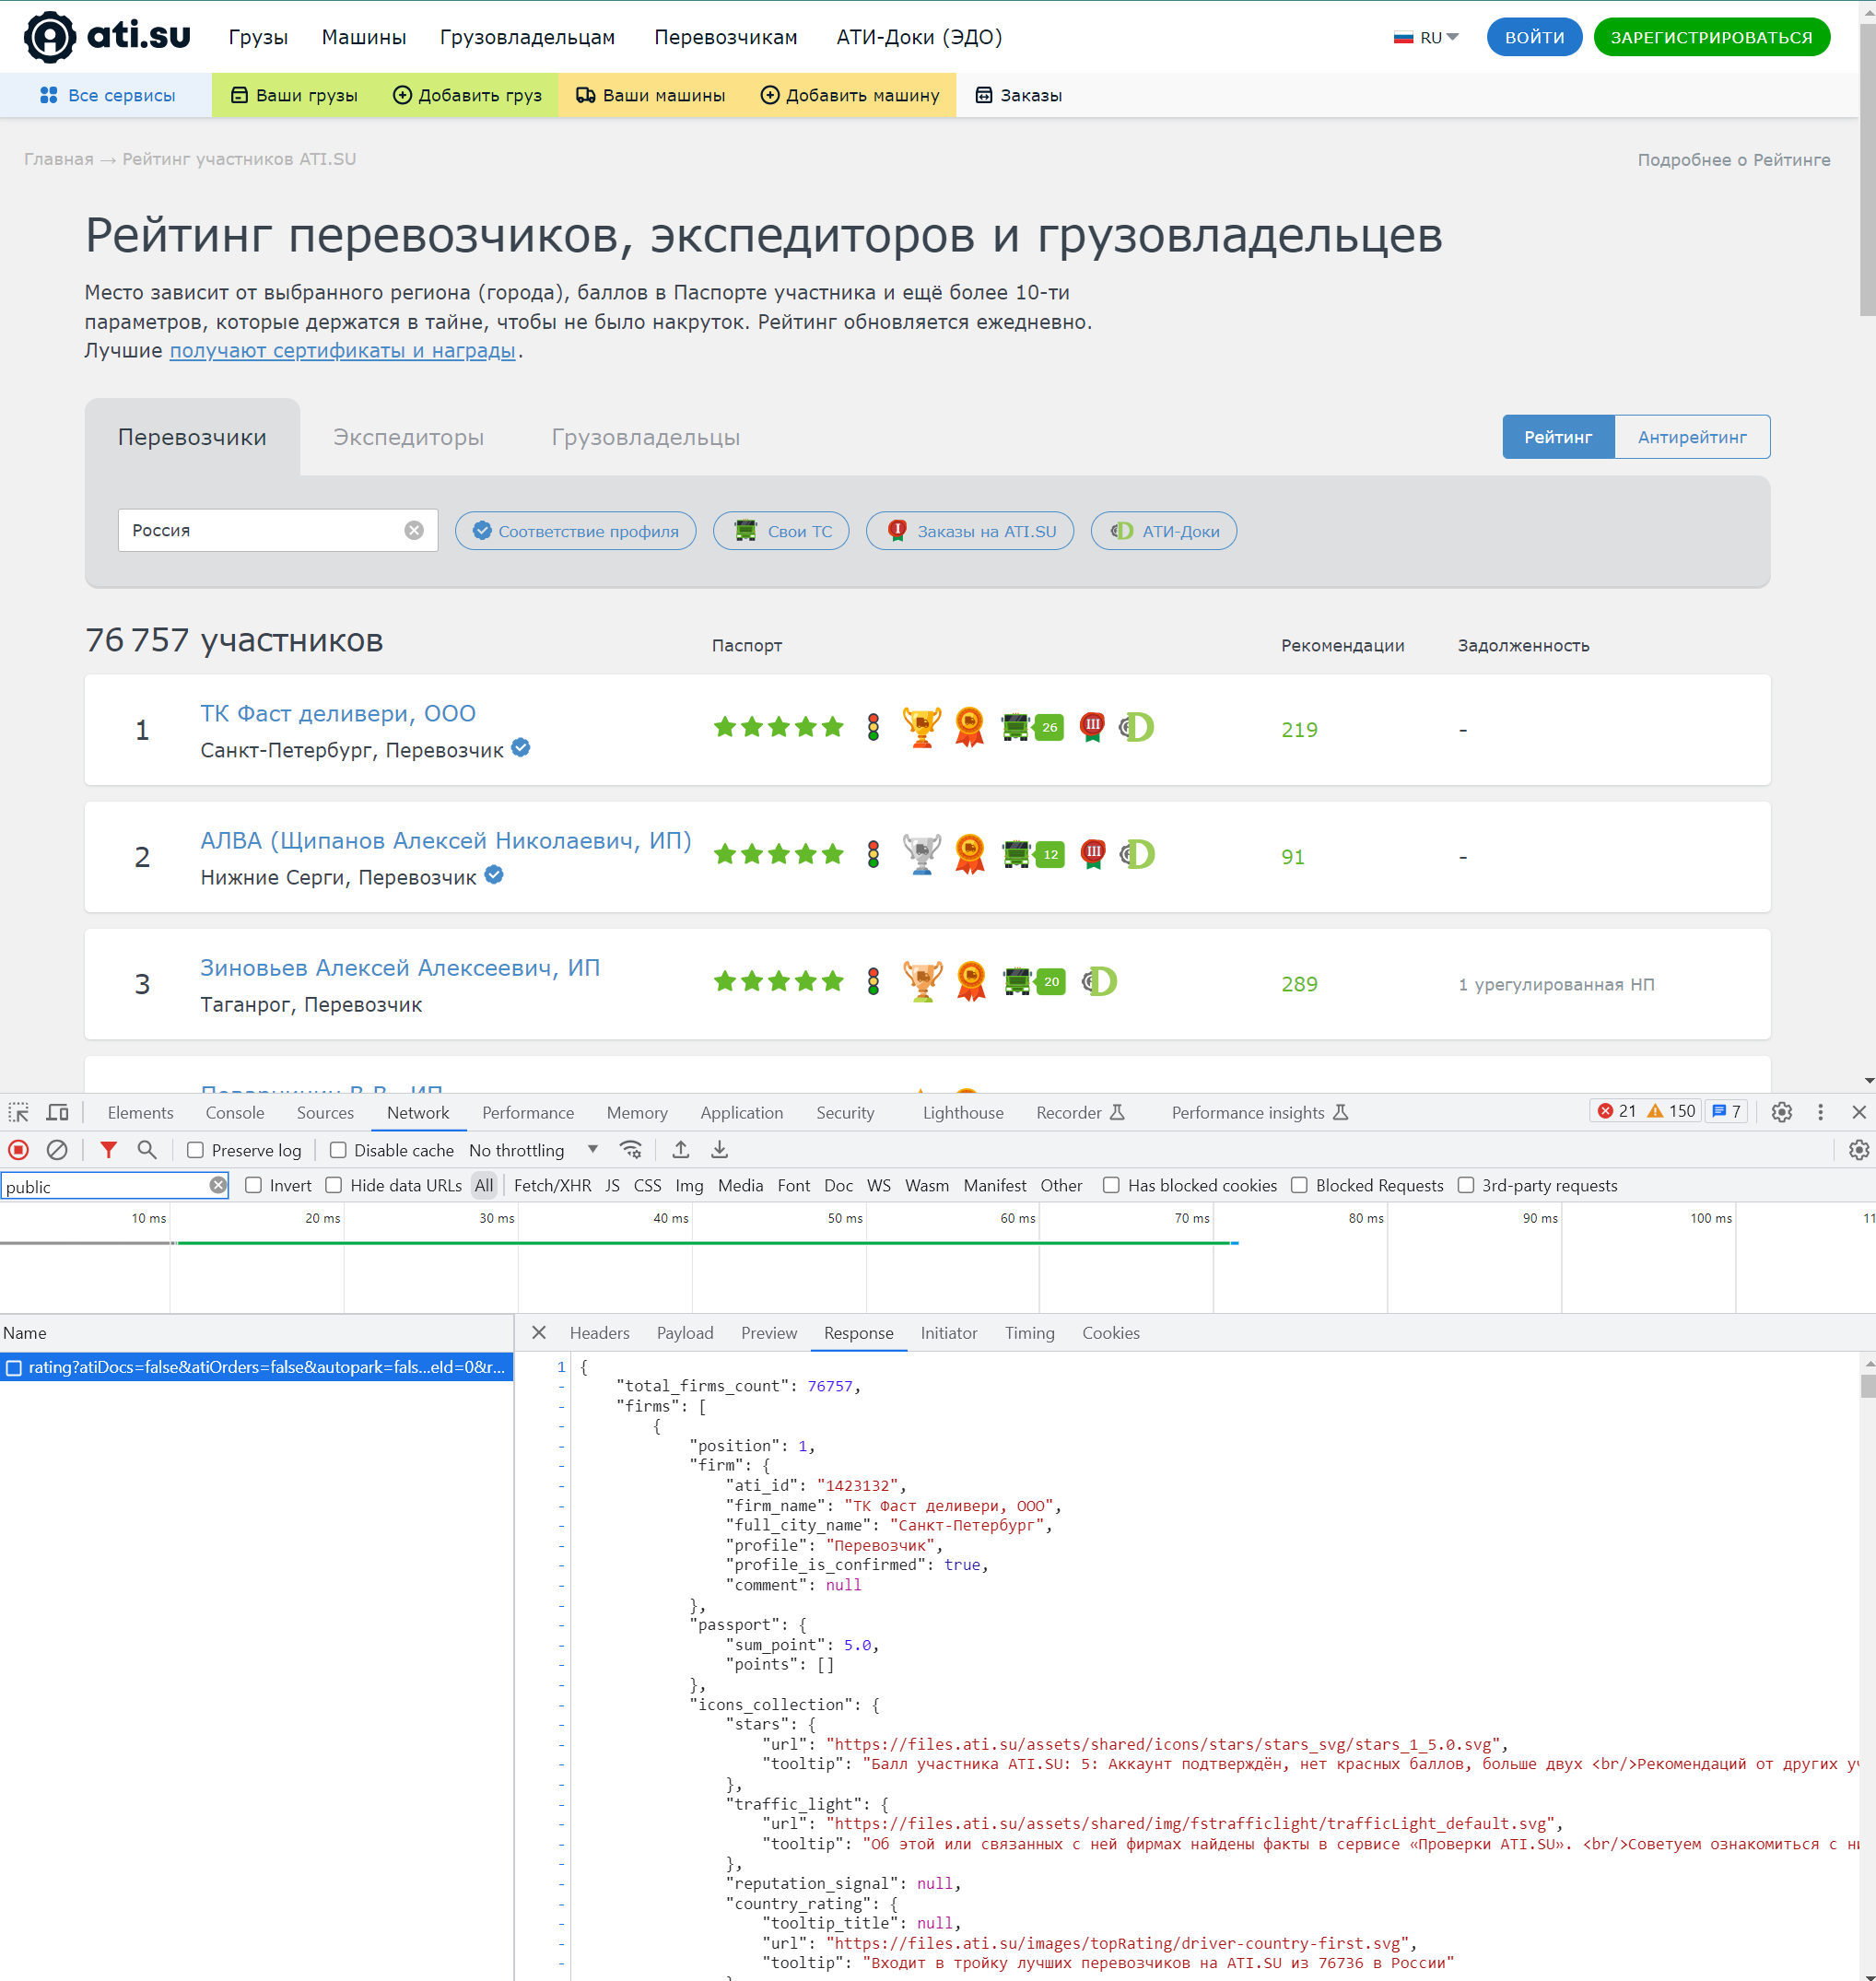

Убираем всё лишнее и оптимизируем запрос, остаётся `firmTypes` и `take`, который возвращает количество фирм в данной категории и данные 300 участников:

https://ati.su/gw/rating-page-service/public/v1/rating?firmTypes=1&take=300


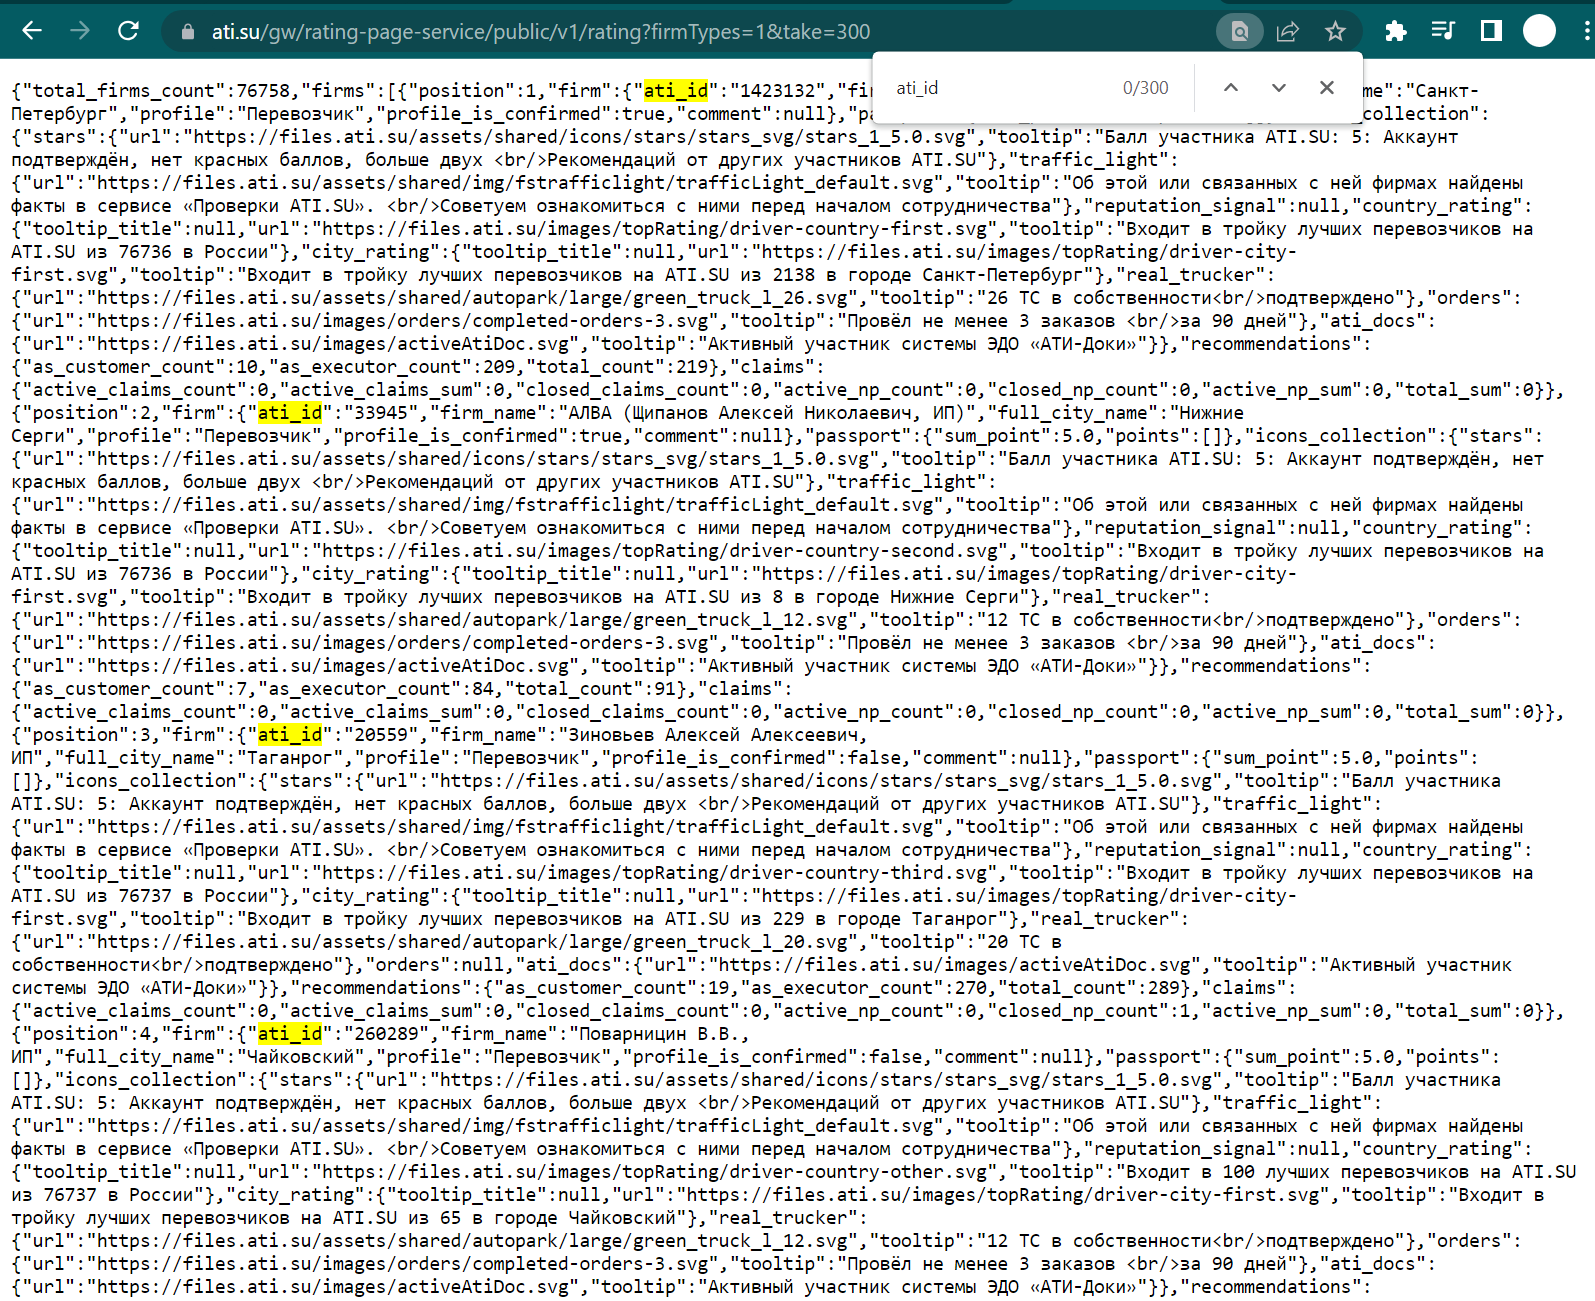

Ответ представляет собой JSON объект и содержит следующие ключи:
- `total_firms_count`: количество фирм в категории;
- `firms` - фирмы, который содержит:
    - `position`: позиция фирмы в списке;
    - `firm`: информация о фирме, который содержит:
        - `ati_id`: ID фирмы в системе ATI.SU;
        - `firm_name`: название фирмы;
        - `full_city_name`: полное название города, в котором находится фирма;
        - `profile`: категория фирмы;
        - `profile_is_confirmed`: подтверждение профиля;
        - `comment`: комментарий.
    - `passport`: паспорт фирмы, который содержит:
        - `sum_point`: суммарный балл паспорта фирмы;
        - `points`: список баллов паспорта фирмы.
    - `icons_collection`: иконки и значки фирмы, который содержит:
        - `stars`: звездочки, который содержит:
            - `url`: URL иконки звезд (ссылка на иконку);
            - `tooltip`: подсказка иконки звезд.
        - `traffic_light`: светофор (объект), который содержит:
            - `url`: URL иконки светофора (ссылка на иконку);
            - `tooltip`: подсказка иконки светофора.
        - `reputation_signal`: сигнал репутации;
        - `country_rating`: рейтинг фирмы по стране, который содержит:
            - `tooltip_title`: заголовок всплывающей подсказки;
            - `url`: URL иконки рейтинга страны (ссылка на иконку);
            - `tooltip`: подсказка иконки рейтинга страны.
        - `city_rating`: рейтинг фирмы по городу, который содержит:
            - `tooltip_title`: заголовок всплывающей подсказки;
            - `url`: URL иконки рейтинга города (ссылка на иконку);
            - `tooltip`: подсказка иконки рейтинга города.
        - `real_trucker`: информация о транспортных средствах фирмы, который содержит:
            - `url`: URL иконки грузовика (ссылка на иконку);
            - `tooltip`: подсказка иконки грузовика.
        - `orders`: заказы, который содержит:
            - `url`: URL иконки заказов (ссылка на иконку);
            - `tooltip`: подсказка иконки заказов.
        - `ati_docs`: документы ATI, который содержит:
            - `url`: URL иконки документов ATI (ссылка на иконку);
            - `tooltip`: подсказка иконки документов ATI.
    - `recommendations`: рекомендации, который содержит:
        - `as_customer_count`: количество рекомендаций в качестве заказчика;
        - `as_executor_count`: количество рекомендаций в качестве исполнителя;
        - `total_count`: общее количество рекомендаций.
    - `claims`: претензии, который содержит:
        - `active_claims_count`: количество активных претензий;
        - `active_claims_sum`: сумма активных претензий;
        - `closed_claims_count`: количество закрытых претензий;
        - `active_np_count`: количество активных НП (Недобросовестый Партнер);
        - `active_np_sum`: сумма активных НП;
        - `closed_np_count`: количество закрытых НП;
        - `total_sum`: общая сумма претензий и НП.
    
Категории фирм:
 - `1` - Перевозчик
 - `2` - Экспедитор
 - `3` - Грузовладелец
 - `4` - Диспетчер
 - `5` - Экспедитор-перевозчик
 - `6` - Грузовладелец-перевозчик    

Пройдемся по всем категориям фирм и посчитаем сколько времени займет парсинг участников (установим задержку, между парсингом 20 сек):

In [2]:
members = 0
p_time = 0
for n in range(1, 7):
    #загрузка данных JSON из URL
    url = "https://ati.su/gw/rating-page-service/public/v1/rating?skip=0&firmTypes="+str(n)+"&take=20"
    response = requests.get(url)
    data = response.json()
    df = pd.json_normalize(data['firms'])
    pages = round(data['total_firms_count'] / 300)
    print(f'В категории {data["firms"][0]["firm"]["profile"]} ({n} из 6) - \
          {data["total_firms_count"]} участников. \
          Парсинг займет ~ {round(pages * 20 / 60)} мин')
    members += data["total_firms_count"]
    p_time += round(pages * 20 / 60)
    time.sleep(1) #задержка между запросами 1 сек
print()
print(f'Всего {members} участников, парсинг займет ~{p_time} мин')

В категории Перевозчик (1 из 6) -           76819 участников.           Парсинг займет ~ 85 мин
В категории Экспедитор (2 из 6) -           3485 участников.           Парсинг займет ~ 4 мин
В категории Грузовладелец (3 из 6) -           16261 участников.           Парсинг займет ~ 18 мин
В категории Диспетчер (4 из 6) -           1921 участников.           Парсинг займет ~ 2 мин
В категории Экспедитор-перевозчик (5 из 6) -           24984 участников.           Парсинг займет ~ 28 мин
В категории Грузовладелец-перевозчик (6 из 6) -           22102 участников.           Парсинг займет ~ 25 мин

Всего 145572 участников, парсинг займет ~162 мин


Напишем функцию для парсинга участников определенной категории:

In [3]:
def parsing_n_type(n):
    df = pd.DataFrame() #создаем пустой датафрейм
    max_attempts = 20 #максимальное кол-во ошибок подряд
    attempts = 0
    while attempts < max_attempts:
        try:
            url = "https://ati.su/gw/rating-page-service/public/v1/rating?skip=0&firmTypes="+str(n)+"&take=1"
            response = requests.get(url)
            data = response.json()
            pages = round(data['total_firms_count'] / 300)
            print(f'В категории {data["firms"][0]["firm"]["profile"]} ({n} из 6) - \
                    {data["total_firms_count"]} участников. \
                    Парсинг займет ~ {round(pages * 20 / 60)} мин')
            break
        except KeyError:
                attempts += 1
                print("Ошибка при парсинге категории:", n, ". Ждём 30 сек, попытка №", attempts)
                time.sleep(30) #задержка после ошибки 30 сек
                continue  #переход к следующей попытке
    else:
            print("Максимальное количество ошибок, остановились на категории:", n)
            
    for i in range(0, pages+1):
        skip = str(300 * i)
        attempts = 0
        while attempts < max_attempts:
            try:
                time.sleep(15) #задержка между запросами 15 сек
                url = "https://ati.su/gw/rating-page-service/public/v1/rating?skip="+skip+"&firmTypes="+str(n)+"&take=300"
                response = requests.get(url)
                data = response.json()
                df300 = pd.json_normalize(data['firms'])
                # Преобразование столбцов со списками в строки
                df = pd.concat([df, df300], join='outer')
                print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Спарсили страницу: {i} из {pages}')
                break  # Выход из цикла while при успешном выполнении запроса
            except KeyError:
                attempts += 1
                print("Ошибка при парсинге страницы:", i, ". Ждём 30 сек, попытка №", attempts)
                time.sleep(10) #задержка после ошибки 30 сек
                continue  #переход к следующей попытке
        else:
            print("Максимальное количество ошибок, остановились на странице:", i)
            
    current_date = datetime.now().strftime("%Y-%m-%d")
    filename = f"cat_{n}_firm_{current_date}.csv"

    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Всё спарсили и сохранили в файл '{filename}'.")

Напишем функцию для парсинга участников всех категорий:

In [4]:
def parsing_all_type():
    df = pd.DataFrame() #создаем пустой датафрейм
    max_attempts = 20 #максимальное кол-во ошибок подряд
    for n in range(1, 7): #парсим категории(от 1 до 6)
        attempts = 0
        while attempts < max_attempts:
            try:
                url = "https://ati.su/gw/rating-page-service/public/v1/rating?skip=0&firmTypes="+str(n)+"&take=1"
                response = requests.get(url)
                data = response.json()
                pages = round(data['total_firms_count'] / 300)
                print(f'В категории {data["firms"][0]["firm"]["profile"]} ({n} из 6) - \
                        {data["total_firms_count"]} участников. \
                        Парсинг займет ~ {round(pages * 20 / 60)} мин')
                break
            except KeyError:
                    attempts += 1
                    print("Ошибка при парсинге категории:", n, ". Ждём 30 сек, попытка №", attempts)
                    time.sleep(30) #задержка после ошибки 30 сек
                    continue  #переход к следующей попытке
        else:
                print("Максимальное количество ошибок, остановились на категории:", n)

        for i in range(0, pages+1):
            skip = str(300 * i)
            attempts = 0
            while attempts < max_attempts:
                try:
                    time.sleep(15) #задержка между запросами 15 сек
                    url = "https://ati.su/gw/rating-page-service/public/v1/rating?skip="+skip+"&firmTypes="+str(n)+"&take=300"
                    response = requests.get(url)
                    data = response.json()
                    df300 = pd.json_normalize(data['firms'])
                    # Преобразование столбцов со списками в строки
                    df = pd.concat([df, df300], join='outer')
                    print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Спарсили страницу: {i} из {pages}')
                    break  # Выход из цикла while при успешном выполнении запроса
                except KeyError:
                    attempts += 1
                    print("Ошибка при парсинге страницы:", i, ". Ждём 30 сек, попытка №", attempts)
                    time.sleep(10) #задержка после ошибки 30 сек
                    continue  #переход к следующей попытке
            else:
                print("Максимальное количество ошибок, остановились на странице:", i)

    current_date = datetime.now().strftime("%Y-%m-%d")
    filename = f"{current_date}_all_firm.csv"

    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"Всё спарсили и сохранили в файл '{filename}'.")

Спарсим всех участников функцией `parsing_all_type`, как это выглядит:
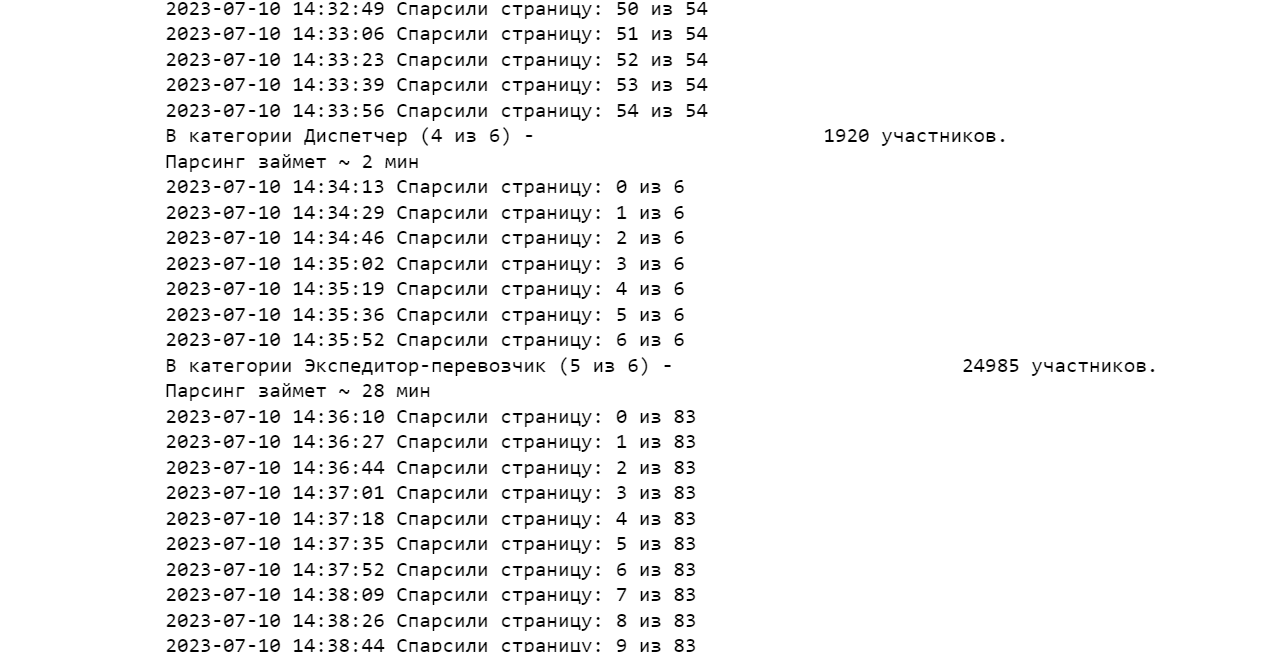

Спарсили всех участников, 145471 за ~ 3ч.

## Откроем файлы с данными и посмотрим общую информацию

Загрузим ранее спарсенные данные:

In [5]:
df = pd.read_csv('2023-07-10_all_firm.csv', index_col=False)
display(df)
df.info()

,position,firm.ati_id,firm.firm_name,firm.full_city_name,firm.profile,firm.profile_is_confirmed,firm.comment,passport.sum_point,passport.points,icons_collection.stars.url,icons_collection.stars.tooltip,icons_collection.traffic_light.url,icons_collection.traffic_light.tooltip,icons_collection.reputation_signal,icons_collection.country_rating.tooltip_title,icons_collection.country_rating.url,icons_collection.country_rating.tooltip,icons_collection.city_rating.tooltip_title,icons_collection.city_rating.url,icons_collection.city_rating.tooltip,icons_collection.real_trucker.url,icons_collection.real_trucker.tooltip,icons_collection.orders.url,icons_collection.orders.tooltip,icons_collection.ati_docs.url,icons_collection.ati_docs.tooltip,recommendations.as_customer_count,recommendations.as_executor_count,recommendations.total_count,claims.active_claims_count,claims.active_claims_sum,claims.closed_claims_count,claims.active_np_count,claims.closed_np_count,claims.active_np_sum,claims.total_sum,icons_collection.orders,icons_collection.ati_docs,icons_collection.real_trucker,icons_collection.country_rating,icons_collection.city_rating,icons_collection.traffic_light,icons_collection.reputation_signal.url,icons_collection.reputation_signal.tooltip
0,1,1423132,"ТК Фаст деливери, ООО",Санкт-Петербург,Перевозчик,True,NaN,5.00,[],https://files.ati.su/assets/shared/icons/stars/stars_svg/stars_1_5.0.svg,"Балл участника ATI.SU: 5: Аккаунт подтверждён, нет красных баллов, больше двух <br/>Рекомендаций от других участников ATI.SU",https://files.ati.su/assets/shared/img/fstrafficlight/trafficLight_default.svg,Об этой или связанных с ней фирмах найдены факты в сервисе «Проверки ATI.SU». <br/>Советуем ознакомиться с ними перед началом ...,NaN,NaN,https://files.ati.su/images/topRating/driver-country-first.svg,Входит в тройку лучших перевозчиков на ATI.SU из 76736 в России,NaN,https://files.ati.su/images/topRating/driver-city-first.svg,Входит в тройку лучших перевозчиков на ATI.SU из 2138 в городе Санкт-Петербург,https://files.ati.su/assets/shared/autopark/large/green_truck_l_26.svg,26 ТС в собственности<br/>подтверждено,https://files.ati.su/images/orders/completed-orders-3.svg,Провёл не менее 3 заказов <br/>за 90 дней,https://files.ati.su/images/activeAtiDoc.svg,Активный участник системы ЭДО «АТИ-Доки»,10,209,219,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,33945,"АЛВА (Щипанов Алексей Николаевич, ИП)",Нижние Серги,Перевозчик,True,NaN,5.00,[],https://files.ati.su/assets/shared/icons/stars/stars_svg/stars_1_5.0.svg,"Балл участника ATI.SU: 5: Аккаунт подтверждён, нет красных баллов, больше двух <br/>Рекомендаций от других участников ATI.SU",https://files.ati.su/assets/shared/img/fstrafficlight/trafficLight_default.svg,Об этой или связанных с ней фирмах найдены факты в сервисе «Проверки ATI.SU». <br/>Советуем ознакомиться с ними перед началом ...,NaN,NaN,https://files.ati.su/images/topRating/driver-country-second.svg,Входит в тройку лучших перевозчиков на ATI.SU из 76736 в России,NaN,https://files.ati.su/images/topRating/driver-city-first.svg,Входит в тройку лучших перевозчиков на ATI.SU из 8 в городе Нижние Серги,https://files.ati.su/assets/shared/autopark/large/green_truck_l_12.svg,12 ТС в собственности<br/>подтверждено,https://files.ati.su/images/orders/completed-orders-3.svg,Провёл не менее 3 заказов <br/>за 90 дней,https://files.ati.su/images/activeAtiDoc.svg,Активный участник системы ЭДО «АТИ-Доки»,7,84,91,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,20559,"Зиновьев Алексей Алексеевич, ИП",Таганрог,Перевозчик,False,NaN,5.00,[],https://files.ati.su/assets/shared/icons/stars/stars_svg/stars_1_5.0.svg,"Балл участника ATI.SU: 5: Аккаунт подтверждён, нет красных баллов, больше двух <br/>Рекомендаций от других участников ATI.SU",https://files.ati.su/assets/shared/img/fstrafficlight/trafficLight_default.svg,Об этой или связанных с ней фирмах найдены факты в сервисе «Проверки ATI.SU». <br/>Советуем ознакомиться с ними перед началом ...,NaN,NaN,htt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145471 entries, 0 to 145470
Data columns (total 44 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   position                                       145471 non-null  int64  
 1   firm.ati_id                                    145471 non-null  int64  
 2   firm.firm_name                                 145471 non-null  object 
 3   firm.full_city_name                            145471 non-null  object 
 4   firm.profile                                   145471 non-null  object 
 5   firm.profile_is_confirmed                      145471 non-null  bool   
 6   firm.comment                                   0 non-null       float64
 7   passport.sum_point                             145471 non-null  float64
 8   passport.points                                145471 non-null  object 
 9   icons_collection.stars.url           

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
position,145471.0,2.503733e+04,2.191159e+04,1.00,7740.00,17035.0,40399.5,76767.0
firm.ati_id,145471.0,2.477668e+06,1.941223e+06,1.00,1026922.50,2305746.0,3220915.5,9999999.0
firm.comment,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passport.sum_point,145471.0,3.180650e+00,1.120255e+01,-619.75,2.85,4.6,5.0,5.0
icons_collection.reputation_signal,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
icons_collection.country_rating.tooltip_title,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recommendations.as_customer_count,145471.0,1.591736e+01,8.586483e+01,0.00,0.00,1.0,4.0,11768.0
recommendations.as_executor_count,145471.0,1.414171e+01,3.108128e+01,0.00,0.00,4.0,15.0,1972.0
recommendations.total_count,145471.0,3.005906e+01,9.700679e+01,0.00,2.00,8.0,25.0,11945.0
claims.active_claims_count,145471.0,1.684872e-01,1.756498e+00,0.00,0.00,0.0,0.0,209.0


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**   
- 145471 строк и 44 столбцов для исследования;
- проблемы с названиями столбцов;
- обнаружены пропуски.

##  Предобработка данных

Для удобства удалим ненужные столбцы и заменим названия оставшихся:

In [7]:
df.drop(['position', 'firm.comment', 'passport.points', 'claims.active_claims_sum', 'claims.active_np_sum',
         'icons_collection.stars.url', 'claims.total_sum',
         'icons_collection.stars.tooltip', 'icons_collection.traffic_light.url',
         'icons_collection.traffic_light.tooltip', 'icons_collection.reputation_signal',
         'icons_collection.country_rating.tooltip_title', 'icons_collection.country_rating.url',
         'icons_collection.country_rating.tooltip', 'icons_collection.city_rating.tooltip_title',
         'icons_collection.city_rating.url', 'icons_collection.city_rating.tooltip',
         'icons_collection.real_trucker.url', 'icons_collection.orders.url', 
         'icons_collection.ati_docs.url', 'icons_collection.orders', 
         'icons_collection.ati_docs', 'icons_collection.real_trucker',
         'icons_collection.city_rating', 'icons_collection.traffic_light',
         'icons_collection.reputation_signal.url',
         'icons_collection.reputation_signal.tooltip',
         'icons_collection.country_rating'], axis=1, inplace=True)
df = df.rename(columns={'firm.ati_id': 'ati_id',
                   'firm.firm_name': 'firm_name',
                   'firm.full_city_name': 'city',
                   'firm.profile': 'category',
                   'firm.profile_is_confirmed': 'confirmed',
                   'passport.sum_point': 'rating',
                   'icons_collection.real_trucker.tooltip': 'trucks',
                   'icons_collection.orders.tooltip': 'orders_count',
                   'icons_collection.ati_docs.tooltip': 'ati_docs',
                   'recommendations.as_customer_count': 'recom_as_customer',
                   'recommendations.as_executor_count': 'recom_as_executor',
                   'recommendations.total_count': 'recom_total',
                   'claims.active_claims_count': 'active_claims_count',
                   'claims.closed_claims_count': 'closed_claims_count',
                   'claims.active_np_count': 'active_np_count',
                   'claims.closed_np_count': 'closed_np_count'
                  })

Оставим в колонке `trucks` количество ТС в собственности участника:

In [8]:
df['trucks'] = df['trucks'].str.replace(r'\D', '')

Оставим в колонке `orders_count` не менее N заказов с контрагентами за 90 дней:

In [9]:
df['orders_count'] = df['orders_count'].str.extract(r'(\d+)')

Оставим в колонке `ati_docs` - *True*, если "Активный участник системы ЭДО «АТИ-Доки»", иначе *False*:

In [10]:
df['ati_docs'] = df['ati_docs'].str.contains("Активный участник системы ЭДО «АТИ-Доки»").fillna(False)

Создадим новый столбец `firm_type` , запишем туда популярные типы организаций участников (ИП, ООО, физ.лицо):

In [11]:
df['firm_type'] = df['firm_name'].str.extract(r'(ИП|ООО|физ.лицо)')
#все оставшиеся типы запишем как "другие"
df['firm_type'].fillna('другие', inplace=True)

Изменим тип данных в столбцах:

In [12]:
df['trucks'].replace('', np.nan, inplace=True)
df['trucks'] = df['trucks'].fillna(0).astype('int')
df['orders_count'] = df['orders_count'].fillna(0).astype('int')

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод:**
- удалили ненужные столбцы и добавили новые;
- переименовали названия и значения в столбцах на читабельные;
- изменили типы данных в столбцах, в соответствие с сохранённым в них значениях;    
- избавились от пропусков.

Сохраним очищенные данные:

In [13]:
current_date = datetime.now().strftime("%Y-%m-%d")
filename = f"{current_date}_all_firm_clean.csv"

df.to_csv(filename, index=False, encoding='utf-8-sig')

## Анализ данных

### Найдем топ-20 городов по количеству фирм и изучим их рейтинг

,city,Количество участников,"%, от всех городов",Средняя оценка,Медианная оценка
0,Москва,8734,6.00,-0.037351,4.00
1,Санкт-Петербург,5811,3.99,2.222333,4.55
2,Екатеринбург,3354,2.31,2.726662,4.55
3,Нижний Новгород,2918,2.01,3.380792,4.75
4,Челябинск,2859,1.97,3.012819,4.60
5,Краснодар,2485,1.71,2.929135,4.35
6,Казань,2330,1.60,3.258906,4.70
7,Новосибирск,2148,1.48,2.771136,4.55
8,Ростов-на-Дону,2118,1.46,2.929934,4.70
9,Воронеж,2112,1.45,3.298402,4.75


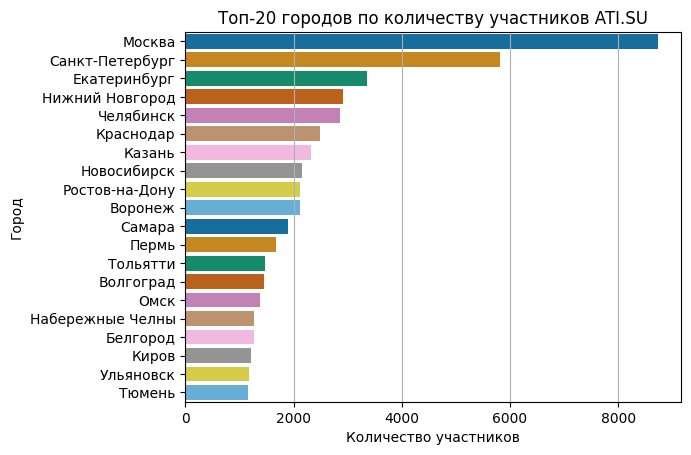

In [14]:
pivot_tab = (df
             .groupby(['city'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='count', ascending=False)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех городов'] = round(
                                  pivot_tab['Количество участников'] / df.shape[0] * 100
                                        , 2)
pivot_tab = pivot_tab[['city', 'Количество участников', 
                       '%, от всех городов', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

sns.barplot(x='Количество участников', 
            y='city', 
            data=pivot_tab, 
            orient='h',
            palette='colorblind'
            )
plt.grid(axis='x')
plt.title("Топ-20 городов по количеству участников ATI.SU")
plt.ylabel("Город")
plt.xlabel("Количество участников")
plt.show();

<div style="border:solid blue 1px; padding: 20px">
    
Больше всего участников ATI.SU из городов:
- Москва, 8734 или 6% от всех данных;
- Санкт-Петербург, 5811, 3.99%;
- Екатеринбург, 3354, 2.31%.

Максимальный рейтинг фирмы может быть *5*, минимальный *-619.75*.

Среднее арифметическое значение и медиана рейтинга разная - чем больше разница, тем больше фирм c отрицательным рейтингом. Чем ближе среднее к медиане, тем более стабильны оценки фирм в данном городе.

Построим диаграмму размаха (*ящик с усами*) для наглядности разброса рейтинга по городам:

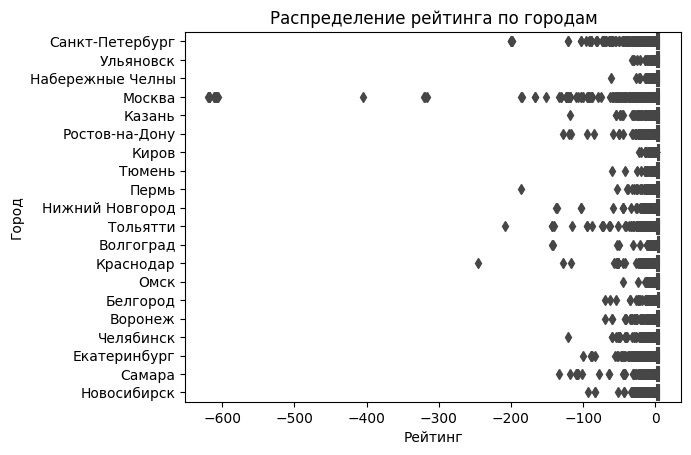

In [15]:
top_20_city = (df["city"]
                 .value_counts()
                 .index[:20]
                 .tolist()
               )
sns.boxplot(y="city", 
            x="rating", 
            data = df.query('city in @top_20_city')
            )
plt.title('Распределение рейтинга по городам')
plt.ylabel('Город')
plt.xlabel('Рейтинг');

На графиках мы видим распределение рейтинга по городам, каждая точка на графике представляет собой участника и его рейтинг. 

Построим "ящик с усами" без выбросов:

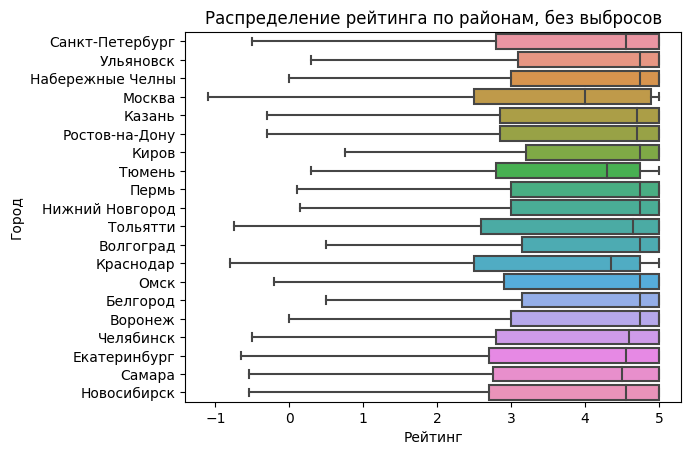

In [16]:
sns.boxplot(y="city", 
            x="rating", 
            data = df.query('city in @top_20_city'), 
            showfliers=False
            )
plt.title('Распределение рейтинга по районам, без выбросов')
plt.ylabel('Город')
plt.xlabel('Рейтинг');

In [17]:
pivot_tab.sort_values('Количество участников')

,city,Количество участников,"%, от всех городов",Средняя оценка,Медианная оценка
19,Тюмень,1163,0.80,3.457309,4.30
18,Ульяновск,1179,0.81,3.708482,4.75
17,Киров,1215,0.84,3.817695,4.75
16,Белгород,1262,0.87,3.413114,4.75
15,Набережные Челны,1269,0.87,3.599330,4.75
14,Омск,1375,0.95,3.611855,4.75
13,Волгоград,1461,1.00,3.533470,4.75
12,Тольятти,1474,1.01,1.580156,4.65
11,Пермь,1675,1.15,3.354582,4.75
10,Самара,1906,1.31,2.573924,4.50


Линия внутри ящика обозначает медианное значение коэффициента, а левая и правая границы ящика соответствуют 25-му и 75-му перцентилю соответствующего распределения. Усы на графике указывают на минимальные и максимальные значения (за исключением выбросов).

<div style="border:solid blue 1px; padding: 20px">
    
- наиболее стабильные очки рейтинга получают участники из городов: Воронеж, Омск, Белгород, Киров, Ульяновск;
- вероятность выбора некачественного участника выше в следующих городах: Москва, Тольятти, Санкт-Петербург, Краснодар, Тюмень.

### Исследуем категории фирм и изучим их рейтинг

,category,Количество участников,"%, от всех категорий",Средняя оценка,Медианная оценка
0,Перевозчик,76767,52.77,3.802038,4.65
1,Экспедитор-перевозчик,24985,17.18,2.418916,4.75
2,Грузовладелец-перевозчик,22086,15.18,2.511584,4.75
3,Грузовладелец,16224,11.15,3.084423,3.50
4,Экспедитор,3490,2.40,-0.065903,4.25
5,Диспетчер,1919,1.32,2.658755,3.40


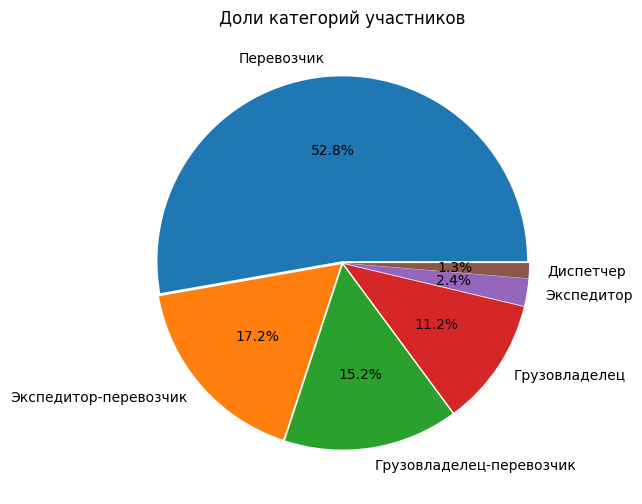

In [18]:
pivot_tab = (df
             .groupby(['category'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='count', ascending=False)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех категорий'] = round(
                                    pivot_tab['Количество участников'] / df.shape[0] * 100
                                          , 2)
pivot_tab = pivot_tab[['category', 'Количество участников', 
                       '%, от всех категорий', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(6, 6))
plt.pie(
        pivot_tab['Количество участников'], 
        labels=pivot_tab.category, 
        autopct='%1.1f%%', explode=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
        )
plt.title("Доли категорий участников");

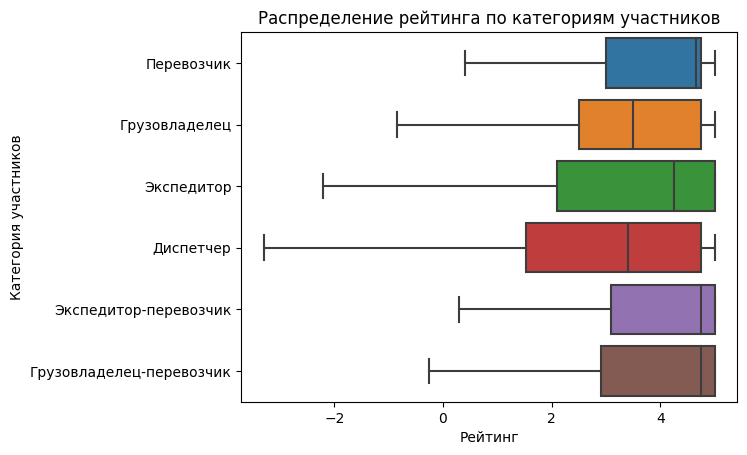

In [19]:
sns.boxplot(y="category", 
            x="rating", 
            data = df, 
            showfliers=False)
plt.title('Распределение рейтинга по категориям участников')
plt.ylabel('Категория участников')
plt.xlabel('Рейтинг');

<div style="border:solid blue 1px; padding: 20px">

- в категории *Перевозчик* 76767 участников, что составляет 52.77% от всех данных;
- наиболее стабильные очки рейтинга получают категории: 
    - *Перевозчик*, медианная оценка 4.65;
    - *Экспедитор-перевозчик*, медианная оценка 4.75;
    - *Грузовладелец-перевозчик*, медианная оценка 4.75;
- вероятность выбора некачественного участника выше в оставшихся категориях.

### Изучим фирмы с подтверждённым  профилем на сайте

,confirmed,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,True,121593,83.59,3.182336,4.7
1,False,23878,16.41,3.172066,4.3


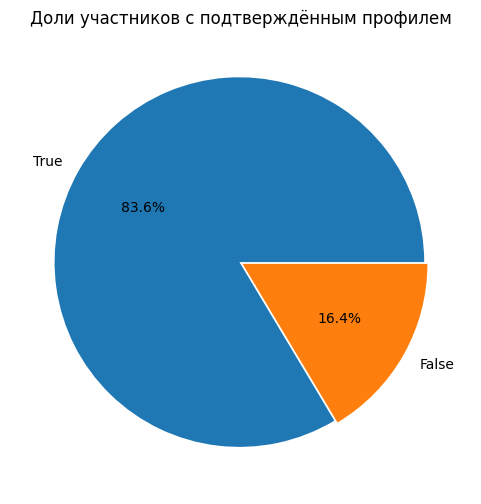

In [20]:
pivot_tab = (df
             .groupby(['confirmed'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='count', ascending=False)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['confirmed', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(6, 6))
plt.pie(
        pivot_tab['Количество участников'], 
        labels=pivot_tab.confirmed, 
        autopct='%1.1f%%', explode=[0.01, 0.01]
        )
plt.title("Доли участников с подтверждённым профилем");

<div style="border:solid blue 1px; padding: 20px">

- фирмы с подтвержденным профилем на сайте составляют 83.6% от общего числа участников ATI.SU и получают более высокую оценку(~ 4.7), чем фирмы с неподтвержденным профилем(~ 4.3).

### Исследуем участников системы ЭДО "АТИ-Доки"

,ati_docs,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,False,134589,92.52,3.162693,4.65
1,True,10882,7.48,3.402741,3.70


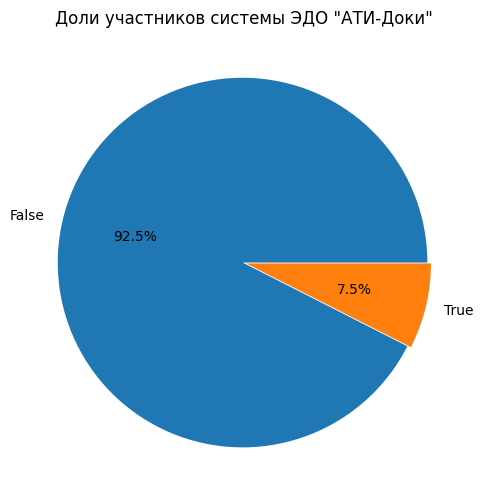

In [21]:
pivot_tab = (df
             .groupby(['ati_docs'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='count', ascending=False)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['ati_docs', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(6, 6))
plt.pie(
        pivot_tab['Количество участников'], 
                  labels=pivot_tab.ati_docs, 
                  autopct='%1.1f%%', explode=[0.01, 0.01]
        )
plt.title('Доли участников системы ЭДО "АТИ-Доки"');

<div style="border:solid blue 1px; padding: 20px">

- лишь 7.5% фирм пользуются сервисом электронного документооборота от сайта ATI.SU, средний рейтинг этих фирм выше, однако медианная оценка ниже по сравнению с фирмами, не участвующими в системе.

### Изучим доли типов фирм

,firm_type,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,ИП,88505,60.84,4.149895,4.75
1,ООО,44028,30.27,1.872441,4.20
2,физ.лицо,10231,7.03,0.481429,1.50
3,другие,2707,1.86,2.970281,3.05


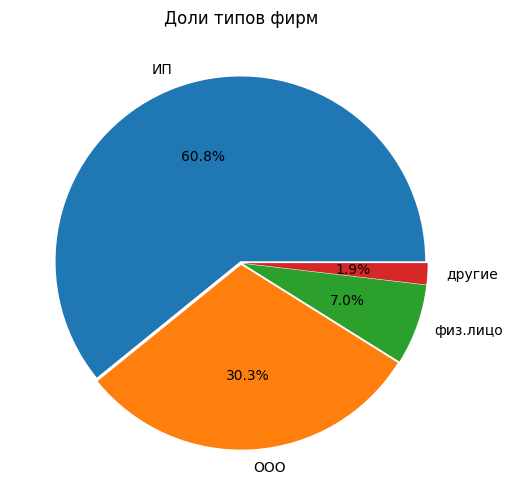

In [22]:
pivot_tab = (df
           .groupby(['firm_type'])['rating']
           .agg(['count', 'mean', 'median'])
           .sort_values(by='count', ascending=False)
           .reset_index()
           .rename(columns={'count': 'Количество участников',
                           'mean': 'Средняя оценка',
                           'median': 'Медианная оценка'})
        ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['firm_type', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(6, 6))
plt.pie(
        pivot_tab['Количество участников'], 
                 labels=pivot_tab.firm_type, 
                 autopct='%1.1f%%', explode=[0.01, 0.01, 0.01, 0.01]
        )
plt.title("Доли типов фирм");

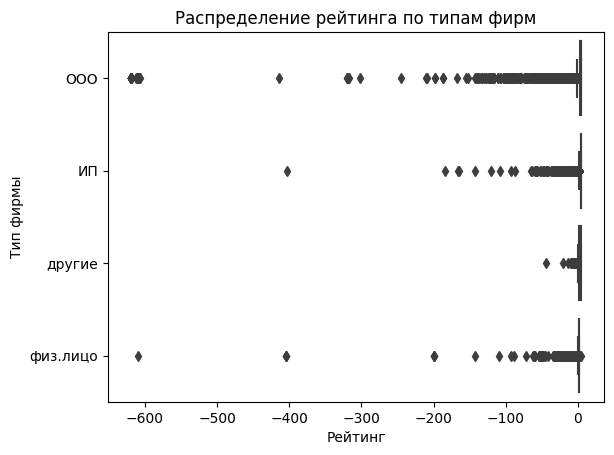

In [23]:
sns.boxplot(y="firm_type", 
            x="rating", 
            data = df)
plt.title('Распределение рейтинга по типам фирм')
plt.ylabel('Тип фирмы')
plt.xlabel('Рейтинг');

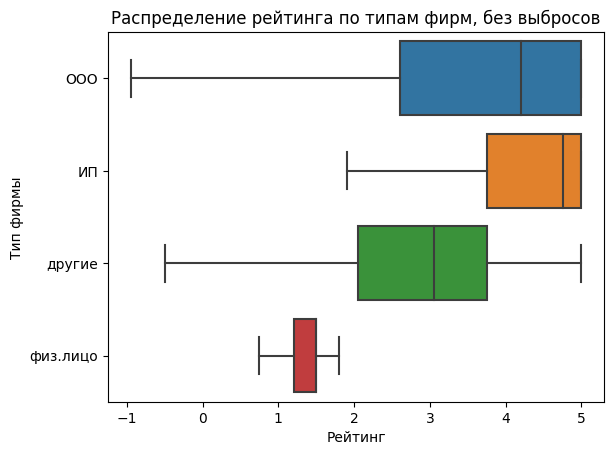

In [24]:
sns.boxplot(y="firm_type", 
            x="rating", 
            data = df, 
            showfliers=False)
plt.title('Распределение рейтинга по типам фирм, без выбросов')
plt.ylabel('Тип фирмы')
plt.xlabel('Рейтинг');

<div style="border:solid blue 1px; padding: 20px">

- участники с типом фирмы "ИП" 88505, что составляет 60.84% от общего числа участников. Категория *ИП* демонстрирует лучшие показатели рейтинга(~ 4.75). Особенно интересно то, что в данной категории наблюдается меньшая разница между средним и медианой, что свидетельствует о более стабильных показателях рейтинга участников этой категории;
- худшие показатели у "физ.лицо", с медианной оценкой рейтинга ~1.5.

### Исследуем количество подтвержденных ТС в собственности участника

,trucks,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,0,136406,93.77,3.120618,4.6
1,1,5629,3.87,3.885259,4.5
2,2,1415,0.97,4.351166,4.9
3,3,629,0.43,4.532790,5.0
4,4,409,0.28,4.518093,5.0
5,5,280,0.19,3.473036,5.0
6,6,158,0.11,4.638608,5.0
7,7,98,0.07,4.624490,5.0
8,8,89,0.06,4.703933,5.0
9,9,55,0.04,4.728182,5.0


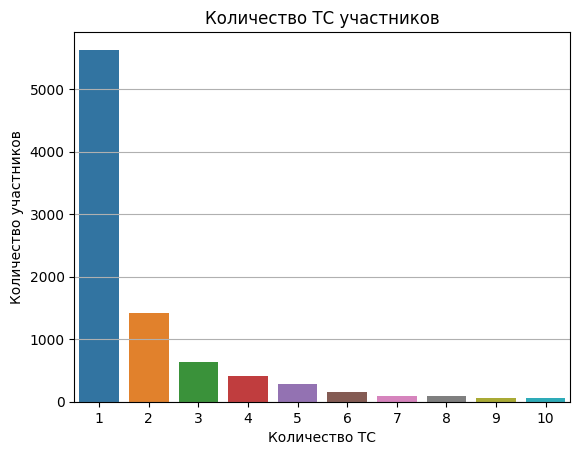

In [25]:
pivot_tab = (df
             .groupby(['trucks'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='trucks', ascending=True)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(11)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['trucks', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

sns.barplot(y='Количество участников', 
            x='trucks', 
            data=pivot_tab[1:]
            )
plt.grid(axis='y')
plt.title("Количество ТС участников")
plt.ylabel("Количество участников")
plt.xlabel("Количество ТС")
plt.show();

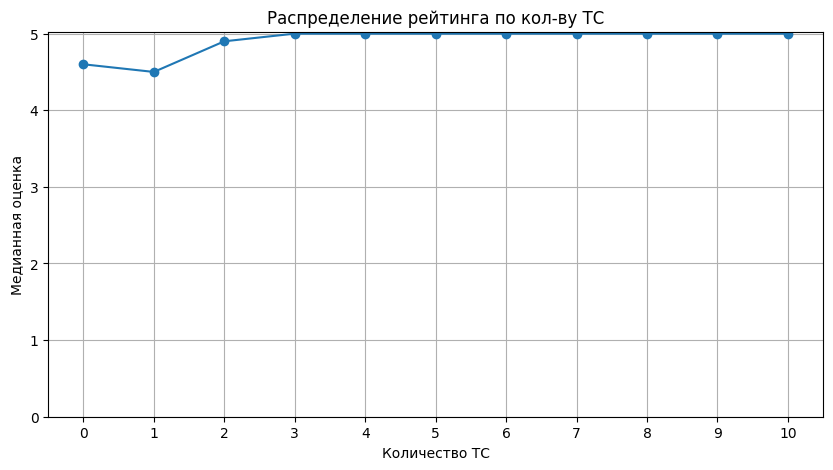

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(pivot_tab['trucks'], 
         pivot_tab['Медианная оценка'], 
         marker='o'
         )
plt.grid()
plt.title('Распределение рейтинга по кол-ву ТС')
plt.xlabel('Количество ТС')
plt.ylabel('Медианная оценка')
plt.ylim(0)
plt.xticks(range(len(pivot_tab['trucks'])), pivot_tab['trucks'])
plt.show()

<div style="border:solid blue 1px; padding: 20px">

- в основном (93.77% от всех данных) участники не имеют подтвержденных ТС в собственности. Их средний рейтинг составляет  ~3.12, а медианная оценка ~4.6;
- с увеличением количества подтвержденных ТС, участники демонстрируют более высокие показатели рейтинга;
- участников с 3 и более подтвержденными ТС небольшое количество, но все их оценки находятся на очень высоком уровне, с медианной оценкой ~5, что свидетельствует о высокой надежности и качестве их услуг.

### Исследуем количество заказов, проведенные за последние 90 дней

In [27]:
pivot_tab = (df
             .groupby(['orders_count'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='count', ascending=False)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(11)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['orders_count', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

,orders_count,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,0,144685,99.46,3.175492,4.6
1,3,609,0.42,3.994828,5.0
2,10,116,0.08,4.570259,5.0
3,50,61,0.04,4.644262,5.0


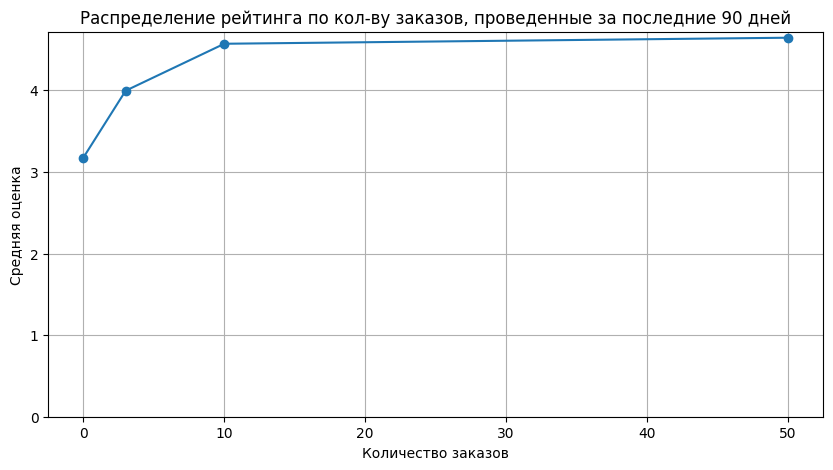

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(pivot_tab['orders_count'], 
         pivot_tab['Средняя оценка'], 
         marker='o'
         )
plt.grid()
plt.title('Распределение рейтинга по кол-ву заказов, проведенные за последние 90 дней')
plt.xlabel('Количество заказов')
plt.ylabel('Средняя оценка')
plt.ylim(0)
plt.show()

<div style="border:solid blue 1px; padding: 20px">

- большинство участников (99.46% от всех данных) не имеют заказов за последние 90 дней, их средний рейтинг составляет ~3.17, а медианная оценка ~4.6;
- участники, которые активно выполняют большое количество заказов за последние 90 дней, имеют более высокий рейтинг и стабильные результаты.

### Исследуем количество рекомендаций

,recom_total,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,0,24837,17.07,2.320289,2.80
1,1,10820,7.44,2.727015,3.35
2,2,8492,5.84,3.009771,3.80
3,3,7317,5.03,3.180569,4.10
4,4,6385,4.39,3.136425,4.30
5,5,5460,3.75,3.354212,4.50
6,6,4877,3.35,3.300067,4.60
7,7,4366,3.00,3.189138,4.70
8,8,3982,2.74,3.630337,4.75
9,9,3510,2.41,3.403048,4.75


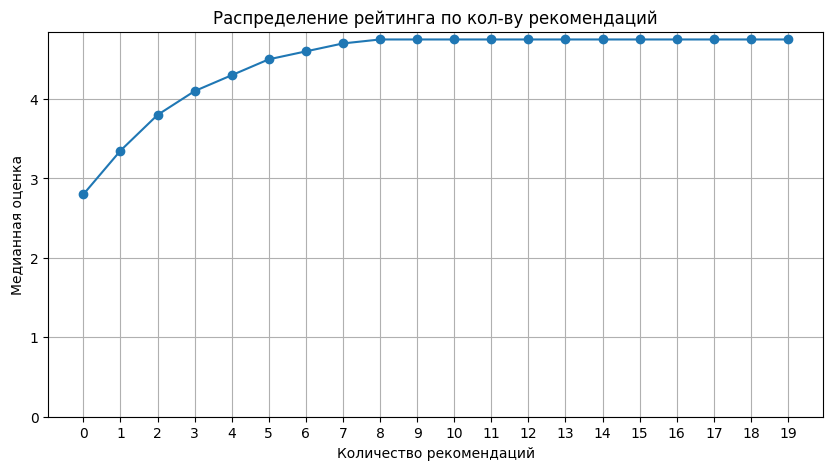

In [29]:
pivot_tab = (df
             .groupby(['recom_total'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='count', ascending=False)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['recom_total', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(10, 5))
plt.plot(pivot_tab['recom_total'], 
         pivot_tab['Медианная оценка'], 
         marker='o'
         )
plt.grid()
plt.title('Распределение рейтинга по кол-ву рекомендаций')
plt.xlabel('Количество рекомендаций')
plt.ylabel('Медианная оценка')
plt.ylim(0)
plt.xticks(range(len(pivot_tab['recom_total'])), pivot_tab['recom_total'])
plt.show()

<div style="border:solid blue 1px; padding: 20px">

- большинство участников (17.07% от всех данных) не имеют ни одной рекомендации, их средний рейтинг составляет ~2.32, а медианная оценка ~2.8;
- участники с 5 и более рекомендациями имеют медианную оценку выше 4.5;
- с увеличением количества рекомендаций наблюдается повышение среднего рейтинга и медианной оценки, это может свидетельствовать о их профессионализме, надежности и качестве работы.

### Исследуем количество претензий от участников ATI.SU

#### Закрытые претензии:

,closed_claims_count,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,0,143388,98.57,3.216217,4.6000
1,1,1208,0.83,2.474876,4.7500
2,2,349,0.24,0.369914,4.5000
3,3,146,0.10,1.400000,4.2250
4,4,111,0.08,-3.895495,4.0000
5,5,50,0.03,-11.350000,3.7000
6,6,36,0.02,0.275000,3.5250
7,7,31,0.02,-0.274194,3.2000
8,8,25,0.02,-3.550000,3.7000
9,9,24,0.02,-4.365625,2.8500


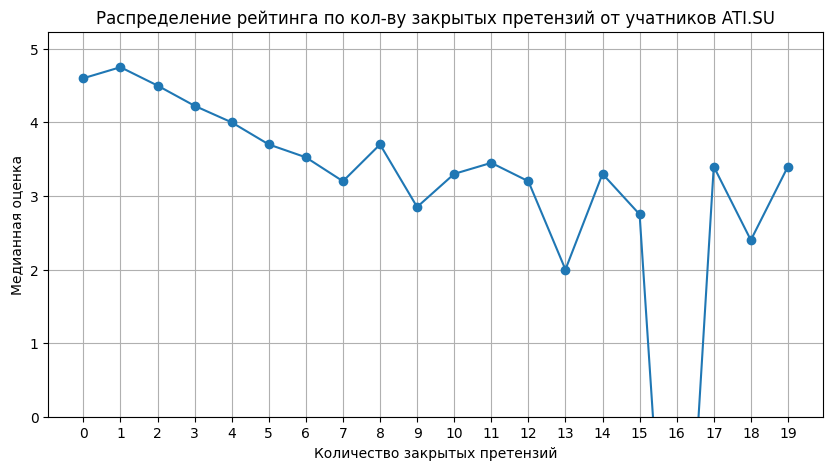

In [30]:
pivot_tab = (df
             .groupby(['closed_claims_count'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='closed_claims_count', ascending=True)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['closed_claims_count', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(10, 5))
plt.plot(pivot_tab['closed_claims_count'], 
         pivot_tab['Медианная оценка'], 
         marker='o'
         )
plt.grid()
plt.title('Распределение рейтинга по кол-ву закрытых претензий от учатников ATI.SU')
plt.xlabel('Количество закрытых претензий')
plt.ylabel('Медианная оценка')
plt.ylim(0)
plt.xticks(range(len(pivot_tab['closed_claims_count'])), pivot_tab['closed_claims_count'])
plt.show()

<div style="border:solid blue 1px; padding: 20px">

- у большинства участников (98.57% от всех данных) нет закрытых претензий, их средний рейтинг составляет ~3.22, а медианная оценка ~4.6;
- участники, имеющие большое количество претензий, обычно имеют более низкий рейтинг. Это может указывать на возможные проблемы или недовольство клиентов в отношении работы этих участников.

#### Активные претензии:

,active_claims_count,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,0,138325,95.09,3.890267,4.750
1,1,3703,2.55,-1.680732,1.000
2,2,1117,0.77,-8.368711,-2.500
3,3,656,0.45,-11.083041,-4.825
4,4,406,0.28,-14.356404,-7.275
5,5,268,0.18,-19.917724,-10.225
6,6,176,0.12,-35.357102,-11.025
7,7,150,0.10,-19.161667,-13.250
8,8,109,0.07,-38.940826,-17.750
9,9,80,0.05,-21.550000,-17.000


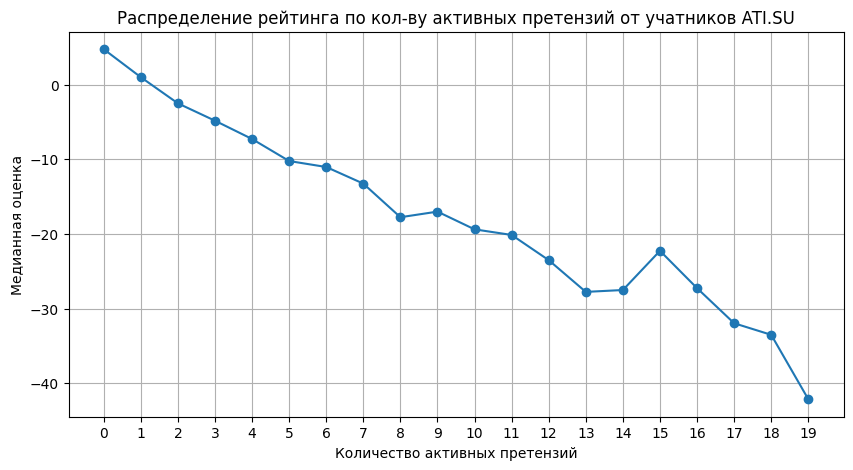

In [31]:
pivot_tab = (df
             .groupby(['active_claims_count'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='active_claims_count', ascending=True)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['active_claims_count', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка',
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(10, 5))
plt.plot(pivot_tab['active_claims_count'], 
         pivot_tab['Медианная оценка'], 
         marker='o'
         )
plt.grid()
plt.title('Распределение рейтинга по кол-ву активных претензий от учатников ATI.SU')
plt.xlabel('Количество активных претензий')
plt.ylabel('Медианная оценка')
plt.xticks(range(len(pivot_tab['active_claims_count'])), pivot_tab['active_claims_count'])
plt.show()

<div style="border:solid blue 1px; padding: 20px">

- у большинства участников (95.1% от всех данных) нет активных претензий, их средний рейтинг составляет ~3.89, а медианная оценка ~4.75;
- участники с активными претензиями имеют отрицательный средний рейтинг и медианную оценку. Чем больше активных претензий у участника, тем более низкий рейтинг.

### Исследуем количество упоминаний на форуме Недобросовестные партнеры (НП)

#### Закрытые упоминание:

,closed_np_count,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,0,137289,94.38,3.236749,4.60
1,1,4096,2.82,2.490009,4.75
2,2,1207,0.83,3.415555,4.80
3,3,583,0.40,1.341338,4.90
4,4,371,0.26,2.939420,4.90
5,5,260,0.18,1.533750,4.95
6,6,214,0.15,3.375234,4.75
7,7,151,0.10,2.404967,4.80
8,8,122,0.08,2.475000,4.90
9,9,113,0.08,3.021681,4.80


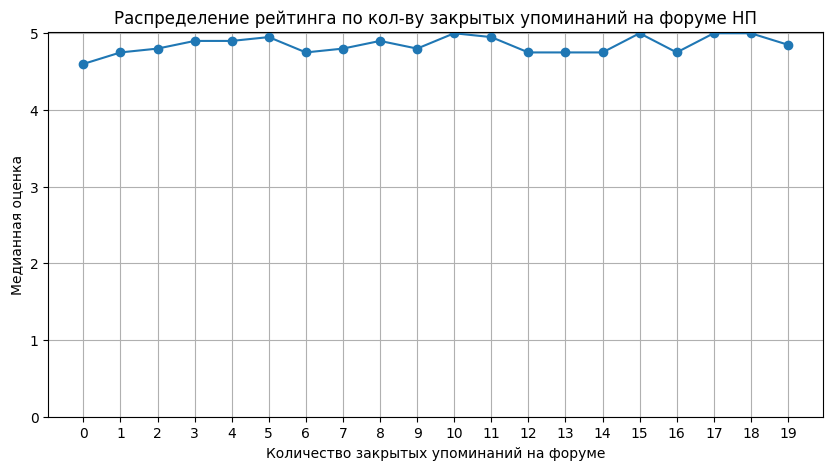

In [32]:
pivot_tab = (df
             .groupby(['closed_np_count'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='closed_np_count', ascending=True)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['closed_np_count', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(10, 5))
plt.plot(pivot_tab['closed_np_count'], 
         pivot_tab['Медианная оценка'], 
         marker='o'
         )
plt.grid()
plt.title('Распределение рейтинга по кол-ву закрытых упоминаний на форуме НП')
plt.xlabel('Количество закрытых упоминаний на форуме')
plt.ylabel('Медианная оценка')
plt.ylim(0)
plt.xticks(range(len(pivot_tab['closed_np_count'])), pivot_tab['closed_np_count'])
plt.show()

<div style="border:solid blue 1px; padding: 20px">

- большинство участников (94.38% от всех данных) не имеют закрытых упоминаний на форуме НП;
- количество закрытых упоминаний на форуме НП не влияет на рейтинг.

#### Активные упоминания:

,active_np_count,Количество участников,"%, от всех участников",Средняя оценка,Медианная оценка
0,0,131862,90.64,3.818740,4.650
1,1,7285,5.01,3.189008,4.750
2,2,1940,1.33,-0.060992,3.800
3,3,992,0.68,-2.352747,1.300
4,4,654,0.45,-4.582301,-0.475
5,5,454,0.31,-6.579075,-1.500
6,6,361,0.25,-8.628809,-4.000
7,7,261,0.18,-9.846169,-3.800
8,8,220,0.15,-10.760114,-3.750
9,9,176,0.12,-9.956250,-6.750


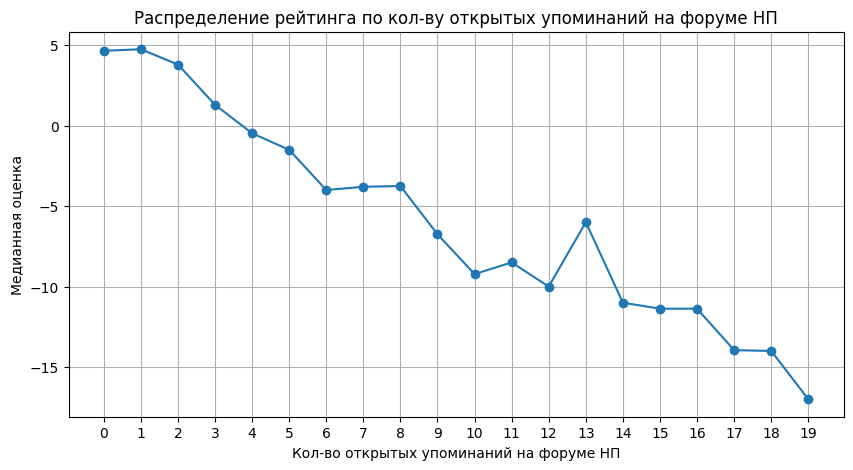

In [33]:
pivot_tab = (df
             .groupby(['active_np_count'])['rating']
             .agg(['count', 'mean', 'median'])
             .sort_values(by='active_np_count', ascending=True)
             .reset_index()
             .rename(columns={'count': 'Количество участников',
                             'mean': 'Средняя оценка',
                             'median': 'Медианная оценка'})
             ).head(20)
pivot_tab['%, от всех участников'] = round(
                                     pivot_tab['Количество участников'] / df.shape[0] * 100
                                           , 2)
pivot_tab = pivot_tab[['active_np_count', 'Количество участников', 
                       '%, от всех участников', 'Средняя оценка', 
                       'Медианная оценка']]
display(pivot_tab)

plt.figure(figsize=(10, 5))
plt.plot(pivot_tab['active_np_count'], 
         pivot_tab['Медианная оценка'], 
         marker='o'
         )
plt.grid()
plt.title('Распределение рейтинга по кол-ву открытых упоминаний на форуме НП')
plt.xlabel('Кол-во открытых упоминаний на форуме НП')
plt.ylabel('Медианная оценка')
plt.xticks(range(len(pivot_tab['active_np_count'])), pivot_tab['active_np_count'])
plt.show()

<div style="border:solid blue 1px; padding: 20px">

- большинство участников (90.64% от всех данных) не имеют открытых упоминаний на форуме НП;    
- активные упоминания на форуме НП существенно снижают средний рейтинг участников. Чем больше активных упоминаний, тем ниже средний рейтинг и медианная оценка. Участники с большим числом активных упоминаний имеют наиболее низкие значения рейтинга и медианной оценки. Это может указывать на то, что активные упоминания на форуме НП связаны с негативными отзывами и проблемами с участниками.

### Исследуем корреляции

Используем корреляцию Phik(𝜙k), т.к. у нас есть категориальные переменные:

interval columns not set, guessing: ['rating', 'trucks', 'orders_count', 'recom_as_customer', 'recom_as_executor', 'recom_total', 'active_claims_count', 'closed_claims_count', 'active_np_count', 'closed_np_count']


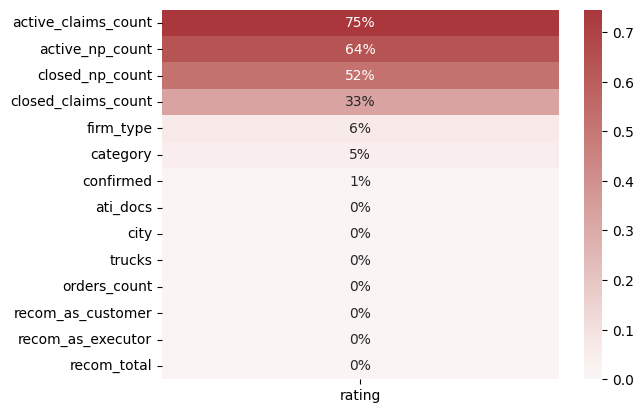

In [34]:
phik_corr_matrix = df.iloc[:, 2:].phik_matrix()

sns.heatmap(
    phik_corr_matrix.loc[:, ['rating']]
                    .drop(['rating'])
                    .sort_values('rating', ascending=False),
                     annot=True, fmt=".0%", 
                     cmap="vlag", center=0
            );

<div style="border:solid blue 1px; padding: 20px">
    
Рейтинг больше всего коррелирует с:
- количеством открытых претензий;
- количеством открытых упоминаний на форуме НП.

Если мы уберем недобросовестных участников (с отрицательным рейтингом), то у нас получится такая корреляция:

interval columns not set, guessing: ['rating', 'trucks', 'orders_count', 'recom_as_customer', 'recom_as_executor', 'recom_total', 'active_claims_count', 'closed_claims_count', 'active_np_count', 'closed_np_count']


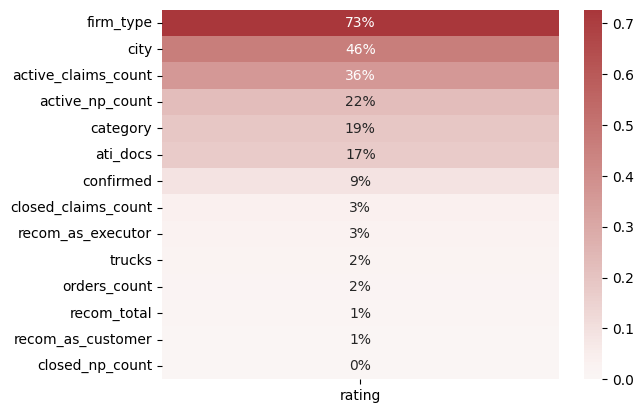

In [35]:
phik_corr_matrix = df.query('rating > 0').iloc[:, 2:].phik_matrix()

sns.heatmap(
    phik_corr_matrix.loc[:, ['rating']]
                    .drop(['rating'])
                    .sort_values('rating', ascending=False),
                     annot=True, fmt=".0%", 
                     cmap="vlag", center=0
            );

<div style="border:solid blue 1px; padding: 20px">
    
У участников с положительным рейтингом, рейтинг больше всего коррелирует с:
- типом фирмы участника;
- городом участника.

## Выберем лучших активных участников ATI.SU

Выберем участников, которые:
- провели не менее 3 заказов за 90 дней;
- количество рекомендаций не меньше 5;
- с рейтингом не меньше 4;
- без активных претензий;
- без открытых упоминаний на форуме НП.

Создадим новый датафрейм `data` и запишем туда их, отсортируем по количеству всех рекомендаций:

In [36]:
data = (df.query('orders_count != 0 & \
                recom_total >= 5 & \
                rating >= 4 & \
                active_claims_count == 0 & \
                active_np_count == 0 ')
          .sort_values('recom_total', ascending=False)
          .reset_index(drop=True)
       )
data.shape

(515, 17)

Осталось 515 участников, посмотрим на первые 20 участников:

In [37]:
data.head(20)

,ati_id,firm_name,city,category,confirmed,rating,trucks,orders_count,ati_docs,recom_as_customer,recom_as_executor,recom_total,active_claims_count,closed_claims_count,active_np_count,closed_np_count,firm_type
0,521159,"ТЛК-Групп (ТЛК-ЦЕНТР, ООО)",Тверь,Экспедитор,False,5.0,0,10,False,11768,177,11945,0,0,0,18,ООО
1,44999,"""Мобил Транс Холдинг"" (Детроид, ООО)",Курган,Грузовладелец-перевозчик,True,5.0,22,50,True,4317,127,4444,0,0,0,0,ООО
2,112132,"АВТОБАН, ООО",Пермь,Экспедитор-перевозчик,True,5.0,20,3,False,3081,173,3254,0,0,0,2,ООО
3,1981996,"Драйв Транс, ООО",Тольятти,Грузовладелец-перевозчик,True,5.0,2,3,True,2759,84,2843,0,0,0,0,ООО
4,807868,"Преснякова Дарья Юрьевна, ИП",Пушкино,Экспедитор-перевозчик,True,5.0,0,3,False,2305,288,2593,0,0,0,0,ИП
5,2004179,"Наконечный Виталий Сергеевич, ИП",Донецк,Грузовладелец-перевозчик,True,4.9,0,50,True,2517,34,2551,0,0,0,0,ИП
6,1366398,"ТрансТехноДон, ООО",Донецк,Грузовладелец-перевозчик,True,5.0,1,3,False,2272,59,2331,0,0,0,12,ООО
7,266655,"Взлет, ООО",Санкт-Петербург,Грузовладелец-перевозчик,True,5.0,0,3,True,2249,29,2278,0,2,0,350,ООО
8,777,"Трак Радар 100% предоплата на погрузке (Система ГрузоВИГ, ООО)",Москва,Экспедитор-перевозчик,True,5.0,4,50,True,1293,751,2044,0,4,0,33,ООО
9,1546074,"Компания А ГРУПП (А-ГРУПП, ООО)",Тольятти,Экспедитор-перевозчик,True,5.0,0,3,False,1745,52,1797,0,0,0,10,ООО


Сохраним отфильтрованные данные:

In [38]:
current_date = datetime.now().strftime("%Y-%m-%d")
filename = f"{current_date}_filtered_firm.csv"

data.to_csv(filename, index=False, encoding='utf-8-sig')

## Выводы

Изучив сайт ATI.SU, мы нашли запрос для выгрузки данных с сайта. Нам удалось спарсить 145471 строк и 44 столбца. Сделали предобработку данных, где мы удалили ненужные столбцы и добавили новые, избавились от пропусков, для последующего анализа оставили 17 столбцов.

В исследовательском анализе данным мы изучили общую информацию, и выявили:
- больше всего участников ATI.SU из городов:
    - Москва, 8734 или 6% от всех данных;
    - Санкт-Петербург, 5811, 3.99%;
    - Екатеринбург, 3354, 2.31%.
- наиболее стабильные очки рейтинга получают участники из городов: Воронеж, Омск, Белгород, Киров, Ульяновск;
- вероятность выбора некачественного участника выше в следующих городах: Москва, Тольятти, Санкт-Петербург, Краснодар, Тюмень;
- в категории *Перевозчик* 76767 участников, что составляет 52.77% от всех данных;
- наиболее стабильные очки рейтинга получают категории: 
    - *Перевозчик*, медианная оценка 4.65;
    - *Экспедитор-перевозчик*, медианная оценка 4.75;
    - *Грузовладелец-перевозчик*, медианная оценка 4.75;
- вероятность выбора некачественного участника выше в оставшихся категориях;
- фирмы с подтвержденным профилем на сайте составляют 83.6% от общего числа участников ATI.SU и получают более высокую оценку(~ 4.7), чем фирмы с неподтвержденным профилем(~ 4.3);
- лишь 7.5% фирм пользуются сервисом электронного документооборота от сайта ATI.SU, средний рейтинг этих фирм выше, однако медианная оценка ниже, по сравнению с фирмами, не участвующими в системе;
- участники с типом фирмы "ИП" 88505, что составляет 60.84% от общего числа участников. Категория *ИП* демонстрирует лучшие показатели рейтинга(~ 4.75). Особенно интересно то, что в данной категории наблюдается меньшая разница между средним и медианой, что свидетельствует о более стабильных показателях рейтинга участников этой категории;
- худшие показатели у "физ.лицо", с медианной оценкой рейтинга ~1.5;
- в основном (93.77% от всех данных) участники не имеют подтвержденных ТС в собственности. Их средний рейтинг составляет  ~3.12, а медианная оценка ~4.6;
- с увеличением количества подтвержденных ТС, участники демонстрируют более высокие показатели рейтинга;
- участников с 3 и более подтвержденными ТС небольшое количество, но все их оценки находятся на очень высоком уровне, с медианной оценкой ~5, что свидетельствует о высокой надежности и качестве их услуг;
- большинство участников (99.46% от всех данных) не имеют заказов за последние 90 дней, их средний рейтинг составляет ~3.17, а медианная оценка ~4.6;
- участники, которые активно выполняют большое количество заказов за последние 90 дней, имеют более высокий рейтинг и стабильные результаты;
- большинство участников (17.07% от всех данных) не имеют ни одной рекомендации, их средний рейтинг составляет ~2.32, а медианная оценка ~2.8;
- участники с 5 и более рекомендациями имеют медианную оценку выше 4.5;
- с увеличением количества рекомендаций наблюдается повышение среднего рейтинга и медианной оценки, это может свидетельствовать о их профессионализме, надежности и качестве работы;
- у большинства участников (98.57% от всех данных) нет закрытых претензий, их средний рейтинг составляет ~3.22, а медианная оценка ~4.6;
- участники, имеющие большое количество претензий, обычно имеют более низкий рейтинг. Это может указывать на возможные проблемы или недовольство клиентов в отношении работы этих участников;
- у большинства участников (95.1% от всех данных) нет активных претензий, их средний рейтинг составляет ~3.89, а медианная оценка ~4.75;
- участники с активными претензиями имеют отрицательный средний рейтинг и медианную оценку. Чем больше активных претензий у участника, тем более низкий рейтинг;
- большинство участников (94.38% от всех данных) не имеют закрытых упоминаний на форуме НП;
- количество закрытых упоминание на форуме НП не влияет на рейтинг;
- большинство участников (90.64% от всех данных) не имеют открытых упоминаний на форуме НП;    
- активные упоминания на форуме НП существенно снижают средний рейтинг участников. Чем больше активных упоминаний, тем ниже средний рейтинг и медианная оценка. Участники с большим числом активных упоминаний имеют наиболее низкие значения рейтинга и медианной оценки. Это может указывать на то, что активные упоминания на форуме НП связаны с негативными отзывами и проблемами с участниками.


*Рейтинг (все оценки) больше всего коррелирует с*:
- количеством открытых претензий;
- количеством открытых упоминаний на форуме НП.

*Рейтинг (только положительные оценки) больше всего коррелирует с*:
- типом фирмы участника;
- городом участника.

Чтобы отфильтровать, и взять *лучших активных участников*, выделим сегмент:
- провели не менее 3 заказов за 90 дней;
- количество рекомендаций не меньше 5;
- с рейтингом не меньше 4;
- без активных претензий;
- без открытых упоминаний на форуме НП.

Таким образом у нас осталось 515 участников.